In [1]:
import torch
from torch.autograd import Variable

In [2]:
import pyro
import pyro.distributions as dist

In [ ]:
mu = Variable( torch.zeros(1) )
sigma = Variable( torch.ones(1) )

In [ ]:
x = dist.normal( mu,sigma )

In [ ]:
x

In [ ]:
log_p_x = dist.normal.log_pdf(x,mu,sigma)

In [ ]:
log_p_x

In [ ]:
x = pyro.sample( "piyank", dist.normal, mu, sigma )
print(x)

In [ ]:
def weather():
    cloudy = pyro.sample( "cloudy", dist.bernoulli, Variable(torch.Tensor([0.3])))
    cloudy = 'cloudy' if cloudy.data[0]==1.0 else 'sunny'
    
    mean_temp = { 'cloudy':[55.0] , 'sunny':[75.0] }[cloudy]
    sigma_temp = { 'cloudy': [10.0], 'sunny': [15.0] }[cloudy]
    
    temp = pyro.sample('temp', dist.normal, Variable(torch.Tensor(mean_temp)), Variable(torch.Tensor(sigma_temp)))
    
    return cloudy, temp.data[0]
    

for i in range(10):
    print( weather() )


In [ ]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = [200] if cloudy == 'sunny' else [50]
    
    ice_cream = pyro.sample( 'ice_cream' , dist.normal , Variable( torch.Tensor(expected_sales) ),
                                                         Variable( torch.Tensor([10.0]) ) )
    return ice_cream

In [ ]:
ice_cream_sales()

In [ ]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample( "x_{}".format(t) , dist.bernoulli, p )
    if x.data[0] == 0:
        return x
    else:
        return x + geometric(p,t+1)

In [ ]:
ls = []
for i in range(100):
    ls.append( geometric( Variable( torch.Tensor([.5])) ).data[0] )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# x = np.random.normal(size = 1000)
plt.hist(ls, bins=20)
plt.ylabel('count')

In [ ]:
def normal_product( mu, sigma ):
    z1 = pyro.sample( "z1" , dist.normal, mu, sigma )
    z2 = pyro.sample( 'z2' , dist.normal, mu, sigma )
    y = z1*z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", dist.normal,
                            Variable(torch.zeros(1)),
                            Variable(torch.ones(1)))
    fn = lambda sigma: normal_product(mu_latent,sigma)
    return fn

In [ ]:
make_normal_normal()(Variable(torch.ones(1)))

In [ ]:
import seaborn as sns

In [3]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import pyro.infer
import pyro.optim

In [5]:
torch.manual_seed(101)

In [6]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

In [7]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [8]:
posterior

In [11]:
guess = Variable(torch.Tensor([8.5]))

marginal = pyro.infer.Marginal(posterior)
print(marginal(guess))

Variable containing:
 6.7830
[torch.FloatTensor of size 1]



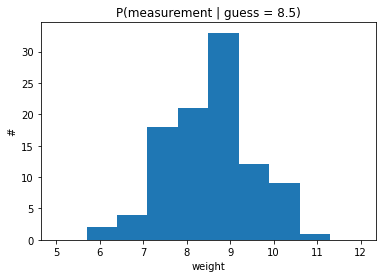

In [12]:
plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess = {})".format(guess.data[0] ) )
plt.xlabel("weight")
plt.ylabel("#")

In [13]:
conditioned_scale = pyro.condition(
    scale, data={"measurement": Variable(torch.Tensor([8.5]))})

In [14]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

In [15]:
def scale_obs(guess):
    weight = pyro.sample( "weight", dist.normal, guess, Variable(torch.Tensor([1.0])) )
    return pyro.sample( "measurement" , dist.normal, weight, Variable(torch.Tensor([0.75])), 
                       obs=Variable(torch.Tensor([0.1])) )

In [16]:
def scale_obs_2(guess):
    weight = pyro.sample( "weight", dist.normal, guess, Variable(torch.Tensor([1.0])) )
    return pyro.observe( "measurement", dist.normal, Variable(torch.Tensor([0.1])),
                        weight, Variable(torch.Tensor([0.75]) ) )

In [17]:
def scale2(guess):
    weight = pyro.sample("weight", dist.normal,
                         guess, Variable(torch.ones(1)))
    tolerance = torch.abs(
        pyro.sample("tolerance", dist.normal, Variable(torch.zeros(1)), Variable(torch.ones(1))))

    return pyro.sample("measurement", dist.normal, weight, tolerance)

conditioned_scale2_1 = pyro.condition( pyro.condition( scale2, 
                                                       data={"weight": Variable(torch.ones(1))}),
                                       data={"measurement": Variable(torch.ones(1))})

conditioned_scale2_2 = pyro.condition( pyro.condition( scale2, 
                                                       data={"measurement": Variable(torch.ones(1))}),
                                       data={"weight": Variable(torch.ones(1))})

conditioned_scale2_3 = pyro.condition( scale2, 
                                       data={"weight": Variable(torch.ones(1)), 
                                             "measurement": Variable(torch.ones(1))})

# all three conditioned_scale2 are equivalent 

In [18]:
conditioned_scale2_1(Variable(torch.Tensor([100000.0])))

Variable containing:
 1
[torch.FloatTensor of size 1]

In [19]:
guess = Variable( torch.Tensor([8.5]) )
measurement = Variable( torch.Tensor([9.5]) )

In [20]:
conditioned_scale = pyro.condition( scale, {'measurement':measurement} )

In [21]:
posterior = pyro.infer.Importance( conditioned_scale, num_samples=100 )
marginal = pyro.infer.Marginal( posterior , sites=['weight','measurement'])

In [22]:
print( marginal(guess))

{'weight': Variable containing:
 8.9660
[torch.FloatTensor of size 1]
, 'measurement': Variable containing:
 9.5000
[torch.FloatTensor of size 1]
}


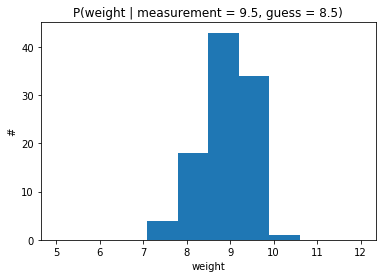

In [24]:
plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement = {0}, guess = {1})".format( measurement.data[0], guess.data[0] ))
plt.xlabel("weight")
plt.ylabel("#")

In [25]:
def scale_prior_guide(guess):
    return pyro.sample('weight', dist.normal, guess, Variable(torch.ones(1)))

posterior = pyro.infer.Importance( conditioned_scale,
                                   guide=scale_prior_guide,
                                   num_samples=100)

marginal = pyro.infer.Marginal( posterior, sites=['weight','measurement'])

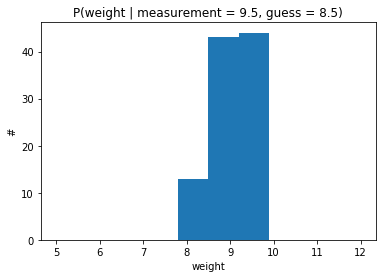

In [26]:
def scale_posterior_guide(measurement,guess):
    a = (guess + torch.sum(measurement))/(measurement.size(0)+1)
    b = Variable( torch.ones(1) )/(measurement.size(0)+1)
    return pyro.sample( 'weight', dist.normal, a, b)

posterior = pyro.infer.Importance( deferred_conditioned_scale,
                                   guide=scale_posterior_guide,
                                   num_samples=20)

marginal = pyro.infer.Marginal( posterior, sites=['weight'])

plt.hist( [marginal(measurement,guess)['weight'].data[0] for _ in range(100)], range=(5.0,12.0 ) )
plt.title("P(weight | measurement = {0}, guess = {1})".format( measurement.data[0], guess.data[0] ))
plt.xlabel("weight")
plt.ylabel("#")

In [27]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", Variable(torch.randn(1) + guess.data.clone(), requires_grad=True))
    b = pyro.param("b", Variable(torch.randn(1), requires_grad=True))
    return pyro.sample("weight", dist.normal, a, torch.abs(b))


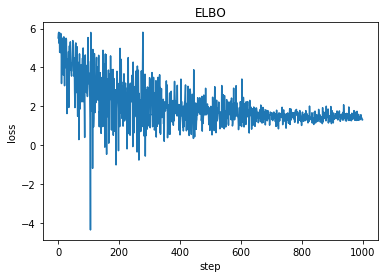

In [28]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss="ELBO")

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

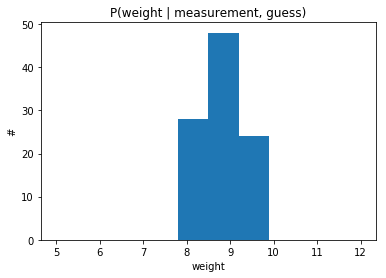

In [29]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.Marginal(posterior, sites=["weight"])

plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

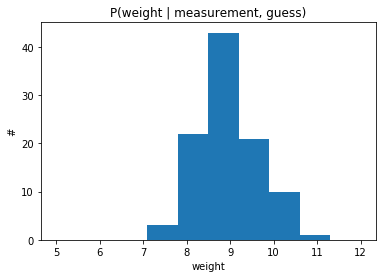

In [30]:
plt.hist([scale_parametrized_guide(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")